### 3D Registration With Fphf & Maximal Cliques
1. This is adapted from [CVPR2023's paper](https://openaccess.thecvf.com/content/CVPR2023/html/Zhang_3D_Registration_With_Maximal_Cliques_CVPR_2023_paper.html) on global registration.
2. Unlike the conventional method of using RANSAC as the hypothesis generator, maximum cliques on graphs are used. Maximal cliques on graphs are regions of the data that captures "interesting" affinity relationships. Theoretically, inliers would form cliques in the graph because rigid point clouds have regions that are geometrically compatible. Thus, using the maximum cliques to generate hypothesis can be a robust solution for correspondence matching.
3. Unlike RANSAC, the returned results of the same data remains consistent. The downside of using maximum clique is that significant time is required to find the cliques.

In [5]:
import open3d as o3d
import numpy as np
import copy
import time
import torch
import os
from igraph import *


def tictoc(func):
    def wrapper(*args, **kwargs):
        t1 = time.perf_counter()
        result = func(*args, **kwargs)
        t2 = time.perf_counter()
        elapsed_time = t2 - t1
        print(f"Time taken by {func.__name__} : {elapsed_time:.6f} seconds")
        return result

    return wrapper


def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)

    # Create line segments to represent coordinate axes
    axis_length = 1.0
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(
        np.array(
            [[0, 0, 0], [axis_length, 0, 0], [0, axis_length, 0], [0, 0, axis_length]]
        )
    )
    line_set.lines = o3d.utility.Vector2iVector(np.array([[0, 1], [0, 2], [0, 3]]))
    line_set.colors = o3d.utility.Vector3dVector(
        np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    )  # RGB colors for X, Y, Z axes

    o3d.visualization.draw_geometries(
        [source_temp, target_temp, line_set],
        zoom=0.4559,
        front=[0.6452, -0.3036, -0.7011],
        lookat=[1.9892, 2.0208, 1.8945],
        up=[-0.2779, -0.9482, 0.1556],
    )


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = o3d.data.DemoICPPointClouds()
src_pcd = o3d.io.read_point_cloud(data.paths[0])
tgt_pcd = o3d.io.read_point_cloud(data.paths[1])
trans_init = np.asarray(
    [
        [0.0, 0.0, 1.0, 0.0],
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ]
)
src_pcd.transform(trans_init)
draw_registration_result(src_pcd, tgt_pcd, np.identity(4))

In [6]:
def transform(pts, trans):
    if len(pts.shape) == 3:
        trans_pts = torch.einsum('bnm,bmk->bnk', trans[:, :3, :3],
                                 pts.permute(0, 2, 1)) + trans[:, :3, 3:4]
        return trans_pts.permute(0, 2, 1)
    else:
        trans_pts = torch.einsum('nm,mk->nk', trans[:3, :3],
                                 pts.T) + trans[:3, 3:4]
        return trans_pts.T
    
def integrate_trans(R, t):
    """
    Integrate SE3 transformations from R and t, support torch.Tensor and np.ndarry.
    Input
        - R: [3, 3] or [bs, 3, 3], rotation matrix
        - t: [3, 1] or [bs, 3, 1], translation matrix
    Output
        - trans: [4, 4] or [bs, 4, 4], SE3 transformation matrix
    """
    if len(R.shape) == 3:
        if isinstance(R, torch.Tensor):
            trans = torch.eye(4)[None].repeat(R.shape[0], 1, 1).to(R.device)
        else:
            trans = np.eye(4)[None]
        trans[:, :3, :3] = R
        trans[:, :3, 3:4] = t.view([-1, 3, 1])
    else:
        if isinstance(R, torch.Tensor):
            trans = torch.eye(4).to(R.device)
        else:
            trans = np.eye(4)
        trans[:3, :3] = R
        trans[:3, 3:4] = t
    return trans

def rigid_transform_3d(A, B, weights=None, weight_threshold=0):
    """
    Input:
        - A:       [bs, num_corr, 3], source point cloud
        - B:       [bs, num_corr, 3], target point cloud
        - weights: [bs, num_corr]     weight for each correspondence
        - weight_threshold: float,    clips points with weight below threshold
    Output:
        - R, t
    """
    bs = A.shape[0]
    if weights is None:
        weights = torch.ones_like(A[:, :, 0])
    weights[weights < weight_threshold] = 0
    # weights = weights / (torch.sum(weights, dim=-1, keepdim=True) + 1e-6)

    # find mean of point cloud
    centroid_A = torch.sum(A * weights[:, :, None], dim=1, keepdim=True) / (
            torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)
    centroid_B = torch.sum(B * weights[:, :, None], dim=1, keepdim=True) / (
            torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    # construct weight covariance matrix
    Weight = torch.diag_embed(weights)  # 升维度，然后变为对角阵
    H = Am.permute(0, 2, 1) @ Weight @ Bm  # permute : tensor中的每一块做转置

    # find rotation
    U, S, Vt = torch.svd(H.cpu())
    U, S, Vt = U.to(weights.device), S.to(weights.device), Vt.to(weights.device)
    delta_UV = torch.det(Vt @ U.permute(0, 2, 1))
    eye = torch.eye(3)[None, :, :].repeat(bs, 1, 1).to(A.device)
    eye[:, -1, -1] = delta_UV
    R = Vt @ eye @ U.permute(0, 2, 1)
    t = centroid_B.permute(0, 2, 1) - R @ centroid_A.permute(0, 2, 1)
    # warp_A = transform(A, integrate_trans(R,t))
    # RMSE = torch.sum( (warp_A - B) ** 2, dim=-1).mean()
    return integrate_trans(R, t)

##### Extract features using fpfh

In [7]:
@tictoc
def extract_fpfh_features(pcd, voxel_size):
    start_time = time.perf_counter()
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.6f} seconds")

    start_time = time.perf_counter()
    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30)
    )
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.6f} seconds")

    start_time = time.perf_counter()
    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100),
    )
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.6f} seconds")

    features = np.array(pcd_fpfh.data).T
    features = features / (
        np.linalg.norm(features, axis=1, keepdims=True) + 1e-6
    )  # rescale to 0~1

    return pcd_down, features


voxel_size = 0.1
src_kpts, src_desc = extract_fpfh_features(src_pcd, voxel_size)
tgt_kpts, tgt_desc = extract_fpfh_features(tgt_pcd, voxel_size)

:: Downsample with a voxel size 0.100.
Time taken: 0.010055 seconds
:: Estimate normal with search radius 0.200.
Time taken: 0.015126 seconds
:: Compute FPFH feature with search radius 0.500.
Time taken: 0.018619 seconds
Time taken by extract_fpfh_features : 0.044136 seconds
:: Downsample with a voxel size 0.100.
Time taken: 0.007058 seconds
:: Estimate normal with search radius 0.200.
Time taken: 0.011753 seconds
:: Compute FPFH feature with search radius 0.500.
Time taken: 0.013644 seconds
Time taken by extract_fpfh_features : 0.032799 seconds


In [8]:
start_time = time.perf_counter()
distance = np.sqrt(2 - 2 * (src_desc @ tgt_desc.T) + 1e-6)
source_idx = np.argmin(distance, axis=1)  # for each row save the index of minimum

# feature matching
corr = np.concatenate(
    [np.arange(source_idx.shape[0])[:, None], source_idx[:, None]], axis=-1
)  # n to 1

src_pts = np.array(src_kpts.points, dtype=np.float32)[corr[:,0]]
tgt_pts = np.array(tgt_kpts.points, dtype=np.float32)[corr[:,1]]

src_pts = torch.from_numpy(src_pts).cuda()
tgt_pts = torch.from_numpy(tgt_pts).cuda()

# graph construction
t1 = time.perf_counter()
inlier_threshold = 0.1
src_dist = ((src_pts[:, None, :] - src_pts[None, :, :]) ** 2).sum(-1) ** 0.5
tgt_dist = ((tgt_pts[:, None, :] - tgt_pts[None, :, :]) ** 2).sum(-1) ** 0.5
cross_dis = torch.abs(src_dist - tgt_dist)
FCG = torch.clamp(1 - cross_dis ** 2 / inlier_threshold ** 2, min=0)
FCG = FCG - torch.diag_embed(torch.diag(FCG))
FCG[FCG < 0.99] = 0
SCG = torch.matmul(FCG, FCG) * FCG
t2 = time.perf_counter()
print(f':: Graph construction: %.2fms' % ((t2 - t1) * 1000))

# search cliques
SCG = SCG.cpu().numpy()
t1 = time.perf_counter()
graph = Graph.Adjacency((SCG > 0).tolist())
graph.es['weight'] = SCG[SCG.nonzero()]
graph.vs['label'] = range(0, corr.shape[0])
graph.to_undirected()

macs = graph.maximal_cliques(min=3)
t2 = time.perf_counter()
print(f"Search maximal cliques: %.2fms" % ((t2 - t1) * 1000))
print(f"Total: %d" % len(macs))
clique_weight = np.zeros(len(macs), dtype=float)
for ind in range(len(macs)):
    mac = list(macs[ind])
    if len(mac) >= 3:
        for i in range(len(mac)):
            for j in range(i + 1, len(mac)):
                clique_weight[ind] = clique_weight[ind] + SCG[mac[i], mac[j]]

clique_ind_of_node = np.ones(corr.shape[0], dtype=int) * -1
max_clique_weight = np.zeros(corr.shape[0], dtype=float)
max_size = 3
for ind in range(len(macs)):
    mac = list(macs[ind])
    weight = clique_weight[ind]
    if weight > 0:
        for i in range(len(mac)):
            if weight > max_clique_weight[mac[i]]:
                max_clique_weight[mac[i]] = weight
                clique_ind_of_node[mac[i]] = ind
                max_size = len(mac) > max_size and len(mac) or max_size

filtered_clique_ind = list(set(clique_ind_of_node))
try:
    filtered_clique_ind.remove(-1)
except:
    pass

print(f'After filtered: %d' % len(filtered_clique_ind))
group = []
for s in range(3, max_size + 1):
    group.append([])
for ind in filtered_clique_ind:
    mac = list(macs[ind])
    group[len(mac) - 3].append(ind)

tensor_list_A = []
tensor_list_B = []
for i in range(len(group)):
    if len(group[i]) == 0:
        continue
    batch_A = src_pts[list(macs[group[i][0]])][None]
    batch_B = tgt_pts[list(macs[group[i][0]])][None]
    if len(group) == 1:
        continue
    for j in range(1, len(group[i])):
        mac = list(macs[group[i][j]])
        src_corr = src_pts[mac][None]
        tgt_corr = tgt_pts[mac][None]
        batch_A = torch.cat((batch_A, src_corr), 0)
        batch_B = torch.cat((batch_B, tgt_corr), 0)
    tensor_list_A.append(batch_A)
    tensor_list_B.append(batch_B)

max_score = 0
final_trans = torch.eye(4)
for i in range(len(tensor_list_A)):
    trans = rigid_transform_3d(tensor_list_A[i], tensor_list_B[i], None, 0)
    pred_tgt = transform(src_pts[None], trans)  # [bs,  num_corr, 3]
    L2_dis = torch.norm(pred_tgt - tgt_pts[None], dim=-1)  # [bs, num_corr]
    MAE_score = torch.div(torch.sub(inlier_threshold, L2_dis), inlier_threshold)
    MAE_score = torch.sum(MAE_score * (L2_dis < inlier_threshold), dim=-1)
    max_batch_score_ind = MAE_score.argmax(dim=-1)
    max_batch_score = MAE_score[max_batch_score_ind]
    if max_batch_score > max_score:
        max_score = max_batch_score
        final_trans = trans[max_batch_score_ind]

@tictoc
def post_refinement(
    initial_trans, src_kpts, tgt_kpts, iters, inlier_threshold=0.1, weights=None
):
    pre_inlier_count = 0
    for i in range(iters):
        pred_tgt = transform(src_kpts, initial_trans)
        L2_dis = torch.norm(pred_tgt - tgt_kpts, dim=-1)
        pred_inlier = (L2_dis < inlier_threshold)[0]
        inlier_count = torch.sum(pred_inlier)
        if inlier_count <= pre_inlier_count:
            break
        pre_inlier_count = inlier_count
        initial_trans = rigid_transform_3d(
            A=src_kpts[:, pred_inlier, :],
            B=tgt_kpts[:, pred_inlier, :],
            weights=1 / (1 + (L2_dis / inlier_threshold) ** 2)[:, pred_inlier],
        )
    return initial_trans


final_trans1 = post_refinement(
    final_trans[None], src_pts[None], tgt_pts[None], 20, inlier_threshold
)

final_trans_cpu = final_trans1.cpu().numpy()
end_time = time.perf_counter()
elapsed_time = end_time - start_time

print(f"Time taken for maximal clique: {elapsed_time:.6f} seconds")
print(f"Transformation = \n{final_trans_cpu[0]}")
draw_registration_result(src_kpts, tgt_kpts, final_trans_cpu[0])

:: Graph construction: 1.44ms


Search maximal cliques: 146.48ms
Total: 16765
After filtered: 941


MAC is robust to outliers and provides consistent results

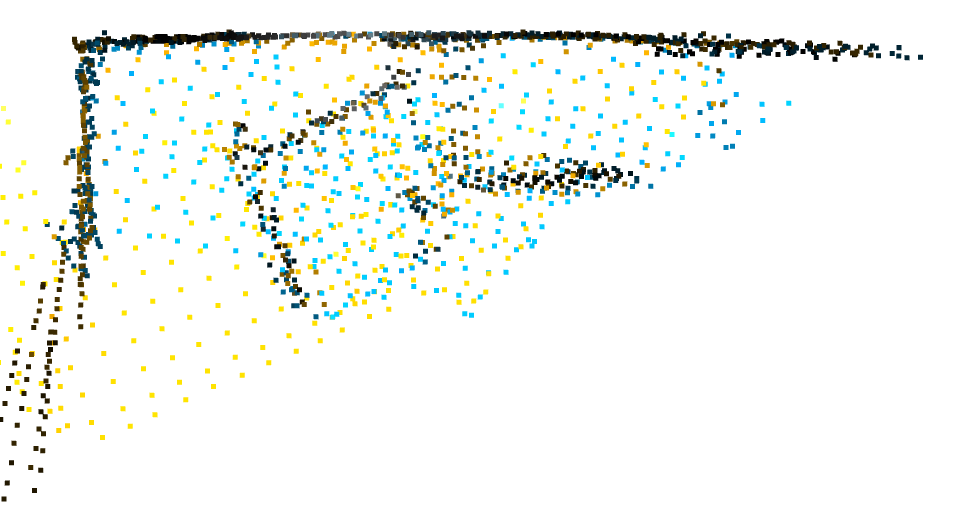